In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [32]:
def plotLine(ax,xRange,w,x0,label,color = 'grey',linestyle = '-', alpha = 1.):
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0,-x0/w[1]]
    yy = -(w[0]/w[1])*(xRange - x0[0]) +x0[1]
    
    ax.plot(xRange,yy,color = color,label = label,linestyle = linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = (np.max(signedDist) - np.min(signedDist)) / np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

In [33]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N =100

In [34]:
def generateBatchBipolar(n,mu = 0.5,sigma = 0.2):
    X = np.random.normal(mu,sigma,(n,2))
    yB = np.random.uniform(0,1,n) >0.5
    
    y = 2.*yB-1
    X*= y[:,None]
    X -= X.mean(axis = 0)
    return X,y

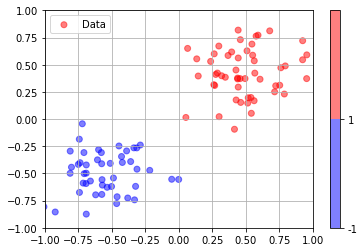

In [35]:
xTrain0, yTrain0 = generateBatchBipolar(N, sigma=0.2)
plotSvm(xTrain0, yTrain0)

In [36]:
class MaxMarginClassifier:
    def __init__(self):
        self.alpha = None
        self.w = None
        self.supportVectors = None
        
    def fit(self,X,y):
        N = len(y)
        
        
        Xy = X*y[:,None]
        GramXy = np.matmul(Xy,Xy.T)
        
        # lagrange dual problem 
        def Ld0(G,alpha):
            return alpha.sum() - 0.5* alpha.dot(alpha.dot(G))
        # partial derivative of ld on alpha
        def Ld0Alpha(G,alpha):
            return np.ones_like(alpha) - alpha.dot(G)
        
        A = -np.eye(N)
        b = np.zeros(N)
        
        constraints = ({'type':'eq','fun': lambda a: np.dot(a,y), 'jac': lambda a:y,},
                      {'type':'ineq','fun':lambda a: b - np.dot(A,a),'jac': lambda a: -A})
        
        optRes = optimize.minimize(fun = lambda a: -Ld0(GramXy,a),
                                  x0 = np.ones(N),
                                  method = 'SLSQP',
                                  jac = lambda a: -Ld0Alpha(GramXy,a),
                                  constraints = constraints)
        
        # lagrange dual problem 
        
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:,np.newaxis]*Xy), axis = 0)
        epsilon = 1e-6
        self.supportVectors = X[self.alpha>epsilon]
        supportLabels = y[self.alpha>epsilon]
        
        self.intercept = supportLabels[0] - np.matmul(self.supportVectors[0].T,self.w)
    
    def predict(self,X):
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        
        return np.sign(X@self.w + self.intercept)

In [37]:
model00 = MaxMarginClassifier()
model00.fit(xTrain0, yTrain0)
model00.w, model00.intercept

(array([3.50946404, 3.17692128]), 0.7689530426428254)

In [38]:
model00.predict(np.array([0.5,0.5]).reshape(1,-1))

array([1.])

Number of support vectors = 3


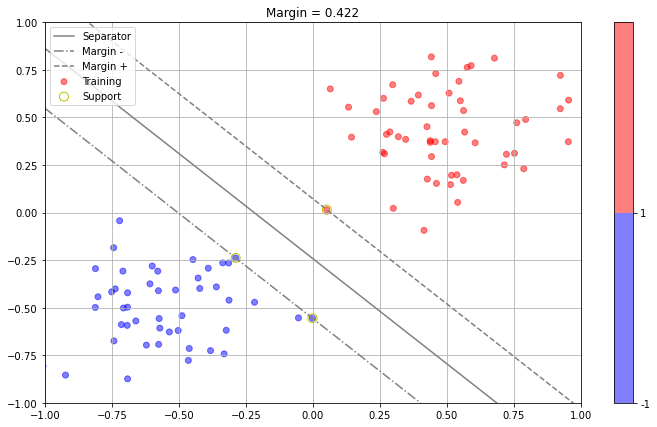

In [39]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(xTrain0, yTrain0, model00.supportVectors, model00.w, model00.intercept, label='Training', ax=ax)

In [40]:
# sciklearn 

model01 = svm.SVC(kernel = 'linear', gamma ='auto',C = 1e6)
model01.fit(xTrain0,yTrain0)
model01.coef_[0],model01.intercept_[0]

(array([3.50739484, 3.17708794]), 0.7688134593627112)

Number of support vectors = 3


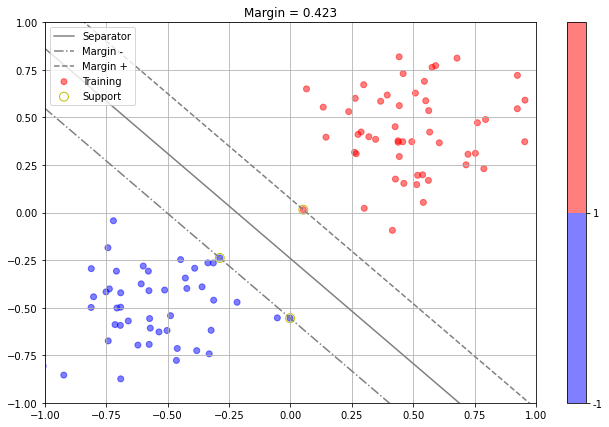

In [41]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, model01.support_vectors_, model01.coef_[0], model01.intercept_[0], 
        label='Training', ax=ax)

In [42]:
model02 = linear_model.LogisticRegression(solver = 'lbfgs')
model02.fit(xTrain0,yTrain0)
model02.coef_[0],model02.intercept_[0]

(array([3.0064418 , 2.69269849]), 0.27069399802972827)

In [43]:
model03 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model03.fit(xTrain0, yTrain0)
model03.coef_[0], model03.intercept_[0]

(array([21.00052826, 18.36726544]), 1.2872093544631191)

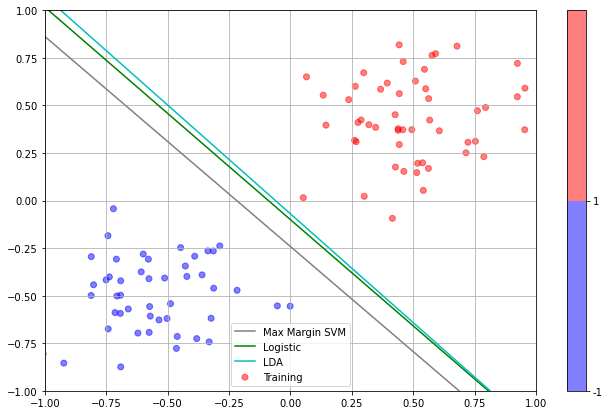

In [44]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain0, yTrain0, w=model01.coef_[0], intercept=model01.intercept_[0], 
        separatorLabel='Max Margin SVM', label='Training', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model02.coef_[0], x0=model02.intercept_[0], label='Logistic', color='g')
plotLine(ax, xx, w=model03.coef_[0], x0=model03.intercept_[0], label='LDA', color='c')
ax.legend();

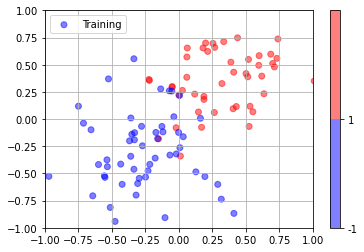

In [45]:
xTrain1, yTrain1 = generateBatchBipolar(N, mu=0.3, sigma=0.3)
plotSvm(xTrain1, yTrain1, label='Training')

In [46]:
class LinearSvmClassifier:
    
    def __init__(self,C):
        self.C =C
        self.alpha = None
        self.w = None
        self.supportVectors = None
        
    def fit(self,X,y):
        
        N = len(y)
        
        Xy = X*y[:,np.newaxis]
        GramXy = np.matmul(Xy,Xy.T)
        
        def Ld0(G,alpha):
            return alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
        
        def Ld0Alpha(G,alpha):
            return np.ones_like(alpha) - alpha.dot(G)
        
        A = np.vstack((-np.eye(N),np.eye(N)))
        b = np.hstack((np.zeros(N),self.C*np.ones(N)))
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A,a), 'jac': lambda a: -A})
        
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0Alpha(GramXy, a), 
                                   constraints=constraints)
        
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        
        self.supportVectors = X[self.alpha > epsilon]
        supportLabels = y[self.alpha > epsilon]
        
        signedDist = np.matmul(self.supportVectors,self.w)[supportLabels == 1.]
        maxDistArg = np.argmax(signedDist)
        
        self.intercept = 1. - signedDist[maxDistArg]
        
    def predict(self,X):
        
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        
        return np.sign(X@self.w + self.intercept)
        

In [47]:
model10 = LinearSvmClassifier(C=1)
model10.fit(xTrain1, yTrain1)
model10.w, model10.intercept

(array([2.35384515, 2.40975639]), -0.18338785049023154)

Number of support vectors = 37


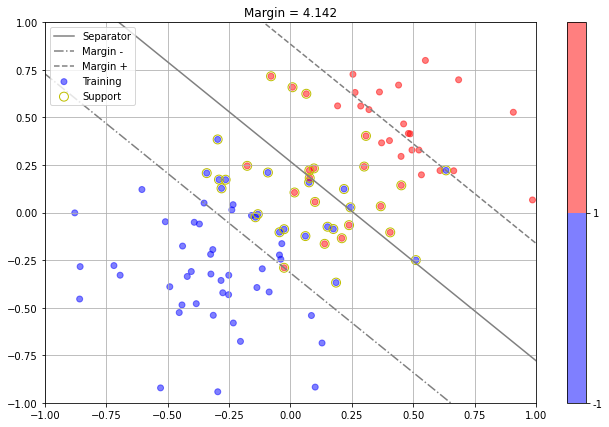

In [48]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model10.supportVectors, model10.w, model10.intercept, label='Training', ax=ax)

In [78]:
model11 = svm.SVC(kernel='linear', gamma='auto', C = 1)
model11.fit(xTrain1, yTrain1)
model11.coef_[0], model11.intercept_[0]

(array([2.35387214, 2.4095015 ]), -0.18355755260240855)

In [79]:
(model11.predict(xTrain1) ==yTrain1).mean()

0.91

Number of support vectors = 36


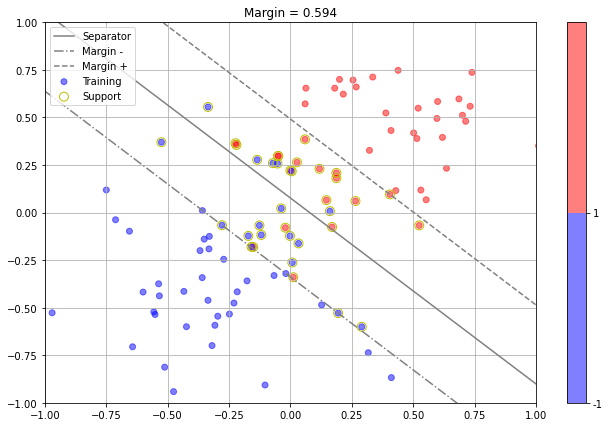

In [82]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model11.support_vectors_, model11.coef_[0], model11.intercept_[0], 
        label='Training', ax=ax)

In [83]:
xTest1, yTest1 = generateBatchBipolar(2*N, mu=0.3, sigma=0.3)

In [63]:
model12 = linear_model.LogisticRegression(solver='lbfgs')
model12.fit(xTrain1, yTrain1)
model12.coef_[0], model12.intercept_[0]
model13 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model13.fit(xTrain1, yTrain1)
model13.coef_[0], model13.intercept_[0]

(array([6.12773426, 5.78819877]), -1.0621728476476056)

In [64]:
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');

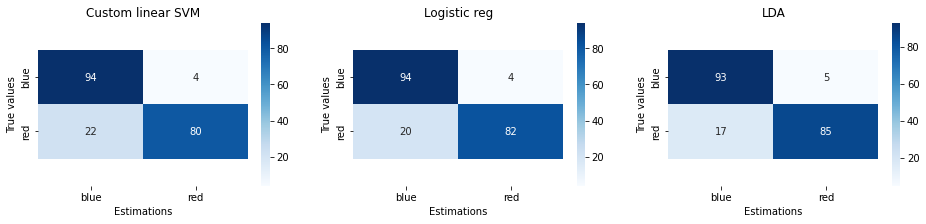

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3))
for model, ax, title in zip([model10, model12, model13], axes, ['Custom linear SVM', 'Logistic reg', 'LDA']):
    yEst = model.predict(xTest1)
    plotConfusionMatrix(yTest1, yEst, colors, title, ax=ax)

# Kernel svm


In [66]:
def generateBatchXor(n, mu=0.5, sigma=0.5):
    """ Four gaussian clouds in a Xor fashion """
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1

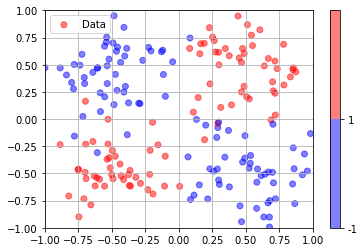

In [67]:
xTrain3, yTrain3 = generateBatchXor(2*N, sigma=0.25)
plotSvm(xTrain3, yTrain3)
xTest3, yTest3 = generateBatchXor(2*N, sigma=0.25)

In [175]:
class KernelSvmClassifier:
    
    def __init__(self,C,kernel):
        self.C =C
        self.kernel = kernel
        self.alpha = None
        self.supportVectors = None
        
    def fit(self,X,y):
        N = len(y)
        hxx = np.apply_along_axis(lambda x1: np.apply_along_axis(lambda x2: self.kernel(x1,x2),1,X),
                                 1,X)
        yp = y.reshape(-1,1)
        GramHXy = hxx*np.matmul(yp,yp.T)
        
        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))
        
        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        
        
        epsilon = 1e-8
        supportIndices = self.alpha>epsilon
        
        self.supportVectors = X[supportIndices]
        self.supportAlphaY =  y[supportIndices] * self.alpha[supportIndices]
        
        support_label = y[supportIndices]
        
        sup_kk =  hxx[supportIndices].T
        sup_kk = sup_kk[supportIndices]*self.supportAlphaY
        
        
        
        sup_kk_sum = sup_kk.sum(axis = 1)
        
        self.intercept = 1. - np.max(sup_kk_sum[support_label ==1.])
         
    def predict(self,X):
        
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s,x),1,self.supportVectors)
            x2 = x1*self.supportAlphaY
            return np.sign(np.sum(x2) + self.intercept)
        
        d = np.apply_along_axis(predict1,1,X)
        # return 2 * (d > 0) - 1
        return d

In [142]:
def GRBF(x1, x2):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

model30 = KernelSvmClassifier(C=5, kernel=GRBF)
model30.fit(xTrain3, yTrain3)

In [143]:
model30.intercept

-0.6304952945460189

Number of support vectors = 49


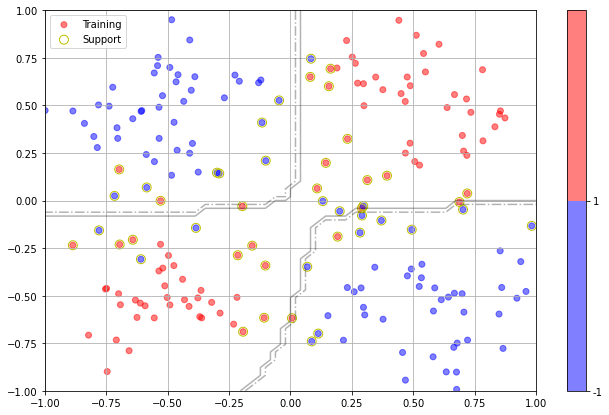

In [144]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model30.supportVectors, label='Training', ax=ax)

xx = np.linspace(-1,1,50)
X0, X1 = np.meshgrid(xx, xx)
xy = np.vstack([X0.ravel(), X1.ravel()]).T
Y30 = model30.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y30, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-'])

Number of support vectors = 53


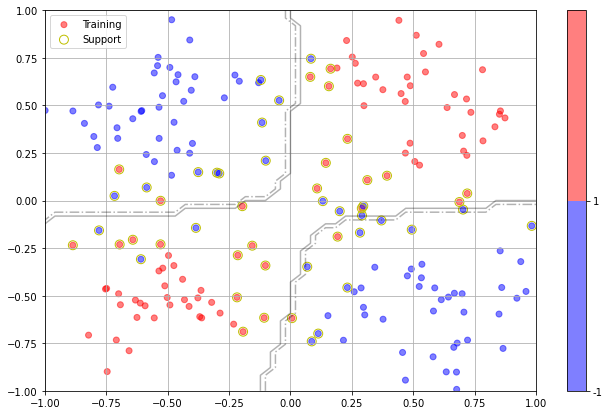

In [174]:
model31 = svm.SVC(kernel='rbf', C=10, gamma=1/2, shrinking=False)
model31.fit(xTrain3, yTrain3)
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model31.support_vectors_, label='Training', ax=ax)
# Estimate and plot decision boundary
Y31 = model31.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y31, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-'])

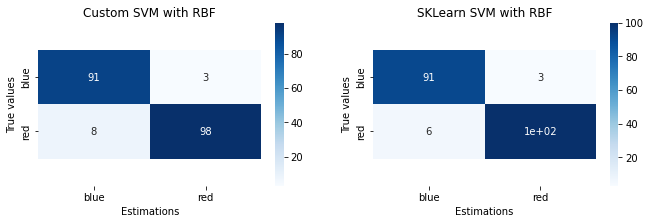

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))
for model, ax, title in zip([model30, model31], axes, ["Custom SVM with RBF", "SKLearn SVM with RBF"]):
    yEst3 = model.predict(xTest3)
    plotConfusionMatrix(yTest3, yEst3, colors, title, ax=ax)

# Alternative solution (not make sure the last slack alpha is betweem 0-C)

In [177]:
import torch
from torch.autograd import Variable

In [1]:
def optimize(K,yTrain3,M,Iter_times = 10000,lr = 0.1):

    lr = 0.1
    Obj_List = []
    old_loss = 0.
    Ky = torch.FloatTensor(K)
    alpha_lack = Variable(torch.FloatTensor(np.zeros((1,M-1))),requires_grad = True)
    y = torch.FloatTensor(yTrain3).view(-1,1)
    
    for it in range(Iter_times):
        alpha_last = -torch.mm(alpha_lack,y[0:M-1,0].reshape(-1,1))/y[M-1]

        Obj = -(torch.sum(alpha_lack) + alpha_last) + 0.5*(alpha_lack@Ky[:M-1,:M-1]@alpha_lack.T +
                                                           alpha_last*Ky[M-1,M-1]*alpha_last +2*alpha_lack@Ky[M-1,:M-1]*alpha_last)
        Obj.backward()
        grad = alpha_lack.grad.data

        lr_temp = lr/(1+it*0.0008)   
        alpha_lack.data = alpha_lack.data - lr_temp*grad
        alpha_lack.grad.data.zero_()

        alpha_lack = torch.clip(alpha_lack,0.,C)
        alpha_lack = Variable(torch.FloatTensor(alpha_lack),requires_grad = True)
        Obj_List.append(Obj)
        
        # if torch.abs(Obj-old_loss) <=1e-6:
        #     break

        
        old_loss = Obj
    final = np.concatenate((alpha_lack.detach().numpy().reshape(-1,),alpha_last.detach().numpy().reshape(-1,)) ) 
    return final
    # for i in range(M):
    #     for j in range(M):
    #         if i != M-1 and j != M-1:
    #             sum_ = sum_ + 0.5*alpha_lack[0,i]*alpha_lack[0,j]*y[i,0]*y[j,0]*K(training_X)
    #         elif i == M-1 and j

In [2]:
class KernelSvmClassifier1:
    
    def __init__(self,C,kernel,solver):
        self.C =C
        self.kernel = kernel
        self.alpha = None
        self.supportVectors = None
        self.solver = solver
        
    def fit(self,X,y):
        N = len(y)
        hxx = np.apply_along_axis(lambda x1: np.apply_along_axis(lambda x2: self.kernel(x1,x2),1,X),
                                 1,X)
        yp = y.reshape(-1,1)
        GramHXy = hxx*np.matmul(yp,yp.T)
        

        self.alpha = self.solver(GramHXy,y,N)
        
        
        epsilon = 1e-8
        supportIndices = self.alpha>epsilon
        
        self.supportVectors = X[supportIndices]
        self.supportAlphaY =  y[supportIndices] * self.alpha[supportIndices]
        
        support_label = y[supportIndices]
        
        sup_kk =  hxx[supportIndices].T
        sup_kk = sup_kk[supportIndices]*self.supportAlphaY
        
        
        
        sup_kk_sum = sup_kk.sum(axis = 1)
        
        self.intercept = 1. - np.max(sup_kk_sum[support_label ==1.])
         
    def predict(self,X):
        
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s,x),1,self.supportVectors)
            x2 = x1*self.supportAlphaY
            return np.sign(np.sum(x2) + self.intercept)
        
        d = np.apply_along_axis(predict1,1,X)
        # return 2 * (d > 0) - 1
        return d

In [3]:
modelxx = KernelSvmClassifier1(C=5, kernel=GRBF,solver = optimize)
modelxx.fit(xTrain3, yTrain3)

NameError: name 'GRBF' is not defined

In [4]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=modelxx.supportVectors, label='Training', ax=ax)

xx = np.linspace(-1,1,50)
X0, X1 = np.meshgrid(xx, xx)
xy = np.vstack([X0.ravel(), X1.ravel()]).T
Y30 = modelxx.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y30, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-'])

NameError: name 'plt' is not defined

In [239]:
final.shape

(200,)

# Gradient Descent SVM

The gradient descent cannot determine which points belong to the support vetors.

In [72]:
class SVMGD:
    
    def __init__(self,state = 'sgd',C = 1,eta = 0.5):
        self.state = state
        self.W = None
        self.b = None
        self.C = C
        self.eta = eta
    def bgd(self,matrix,label,epochs = 200):
        N,D = matrix.shape
        W = np.zeros((1,D))
        b = float(0)
        for j in range(epochs):
            indicator_w = np.multiply(np.multiply(np.multiply(np.transpose(W @ matrix.T) + b, label) < 1, label), matrix)
            indicator_b = np.multiply(np.multiply(np.transpose(W @ matrix.T) + b, label) < 1, label)
            delta_w = W -1*self.C*(np.sum(indicator_w, axis=0))
            delta_b = -1*self.C*(np.sum(indicator_b, axis=0)) 
            
            W -= (self.eta/(1 + j*self.eta))*delta_w
            b -= 0.01*(self.eta/(1 + j*self.eta))*delta_b
            
        return W,b
    
    def sgd(self,matrix,label,epochs = 200):
        N, D = matrix.shape
        W = np.zeros((1,D))
        b = float(0)
        for j in range(1, epochs+1):
            perm = np.random.permutation(N)
            for i in perm:
                delta_w = W/N - self.C*(label[i,0]*(W @ np.transpose(matrix[i, :]) + b) < 1)*label[i,0]*matrix[i, :]
                delta_b = -1*self.C*(label[i,0]*(W @ np.transpose(matrix[i, :]) + b) < 1)*label[i,0]
                W -= (self.eta/(1 + j*self.eta))*delta_w
                b -= 0.01*(self.eta/(1 + j*self.eta))*delta_b
        
        return W,b
    
    def fit(self,train_x,train_y,epochs = 100):
        
        if self.state == 'bgd':
            self.W,self.b = self.bgd(train_x,train_y,epochs = epochs)
        else:
            self.W,self.b = self.sgd(train_x,train_y,epochs = epochs)
        
    def predict(self,matrix):
        output = np.ones( (matrix.shape[0], 1) )
        output = (np.transpose(self.W @ matrix.T) + self.b > 0)*2 - 1
        return output
        

In [80]:
gdmodel = SVMGD(state = 'sgd',C = 1, eta = 0.1)
gdmodel.fit(xTrain1, yTrain1.reshape(-1,1))
gdmodel.W, gdmodel.b

#  (array([2.35384515, 2.40975639]), -0.18338785049023154)
# predict accuracy: 0.91

(array([[2.45786071, 2.53189779]]), array([-0.11994545]))

In [81]:
(gdmodel.predict(xTrain1).reshape(-1) == yTrain1).mean()

0.91